2024-10-15 03:47:23.468045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 03:47:23.522451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 03:47:23.577324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 03:47:23.589263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 03:47:23.636315: I tensorflow/core/platform/cpu_feature_guar

Found 1650 files belonging to 2 classes.
Using 1320 files for training.
Found 1650 files belonging to 2 classes.
Using 330 files for validation.
Index(['filepath', 'label'], dtype='object')


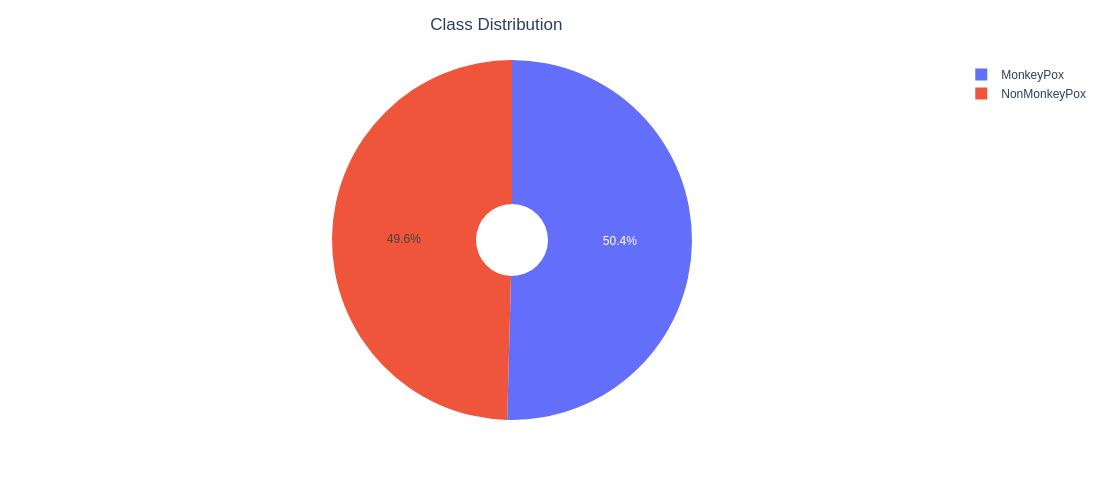

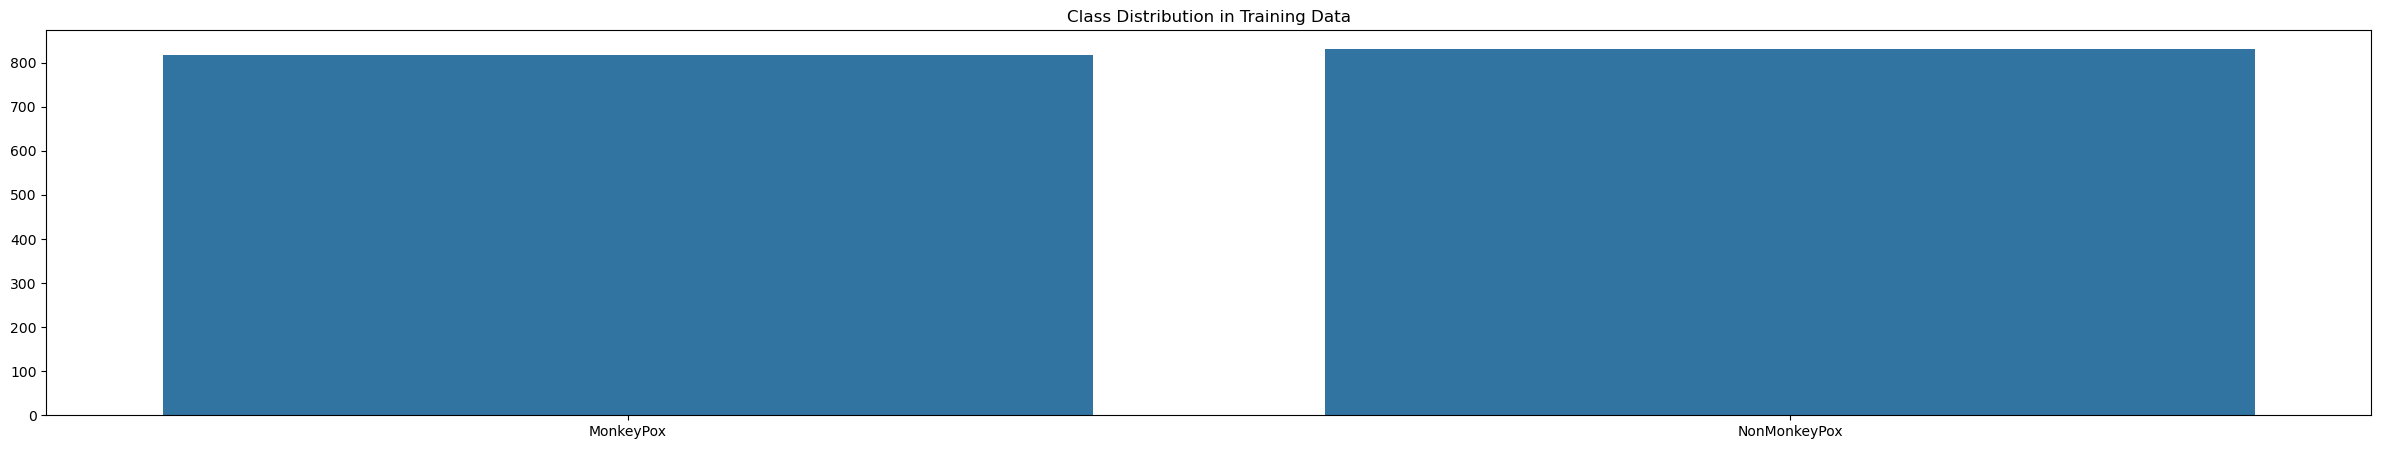

In [1]:
# Required Libraries
import numpy as np 
import pandas as pd 
import os
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Optional - Install Plotly if not already installed
# !pip install plotly

# Plotly for visualization
import plotly.express as px

# Define image dimensions and batch size
image_height = 224
image_weight = 224
batch_size = 32

# Specify the path to your dataset
tpath = 'aug'  # Update this with your local path

# Load the training data using ImageDataGenerator
training_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

# Load the validation data
validation_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

# Load the metadata information (Update the path)
info_file = 'labels_aug.csv'  # Update the path
info = pd.read_csv(info_file)
info.head()

# Check the column names to be sure
print(info.columns)

# Correct the pie chart code to use the lowercase 'label'
fig = px.pie(
    names=info['label'].unique(),  # Corrected to 'label'
    values=info['label'].value_counts(),  # Corrected to 'label'
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Class Distribution', 'x': 0.45}})
fig.show()

# Visualize class distribution in a bar plot
class_names = []
class_count = []
train_examples = 0

# Count the number of images per class
for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)

# Display class distribution as a bar plot
plt.figure(figsize=(30, 5))
sns.barplot(x=class_names, y=class_count)
plt.title("Class Distribution in Training Data")
plt.show()


Found 1321 images belonging to 2 classes.


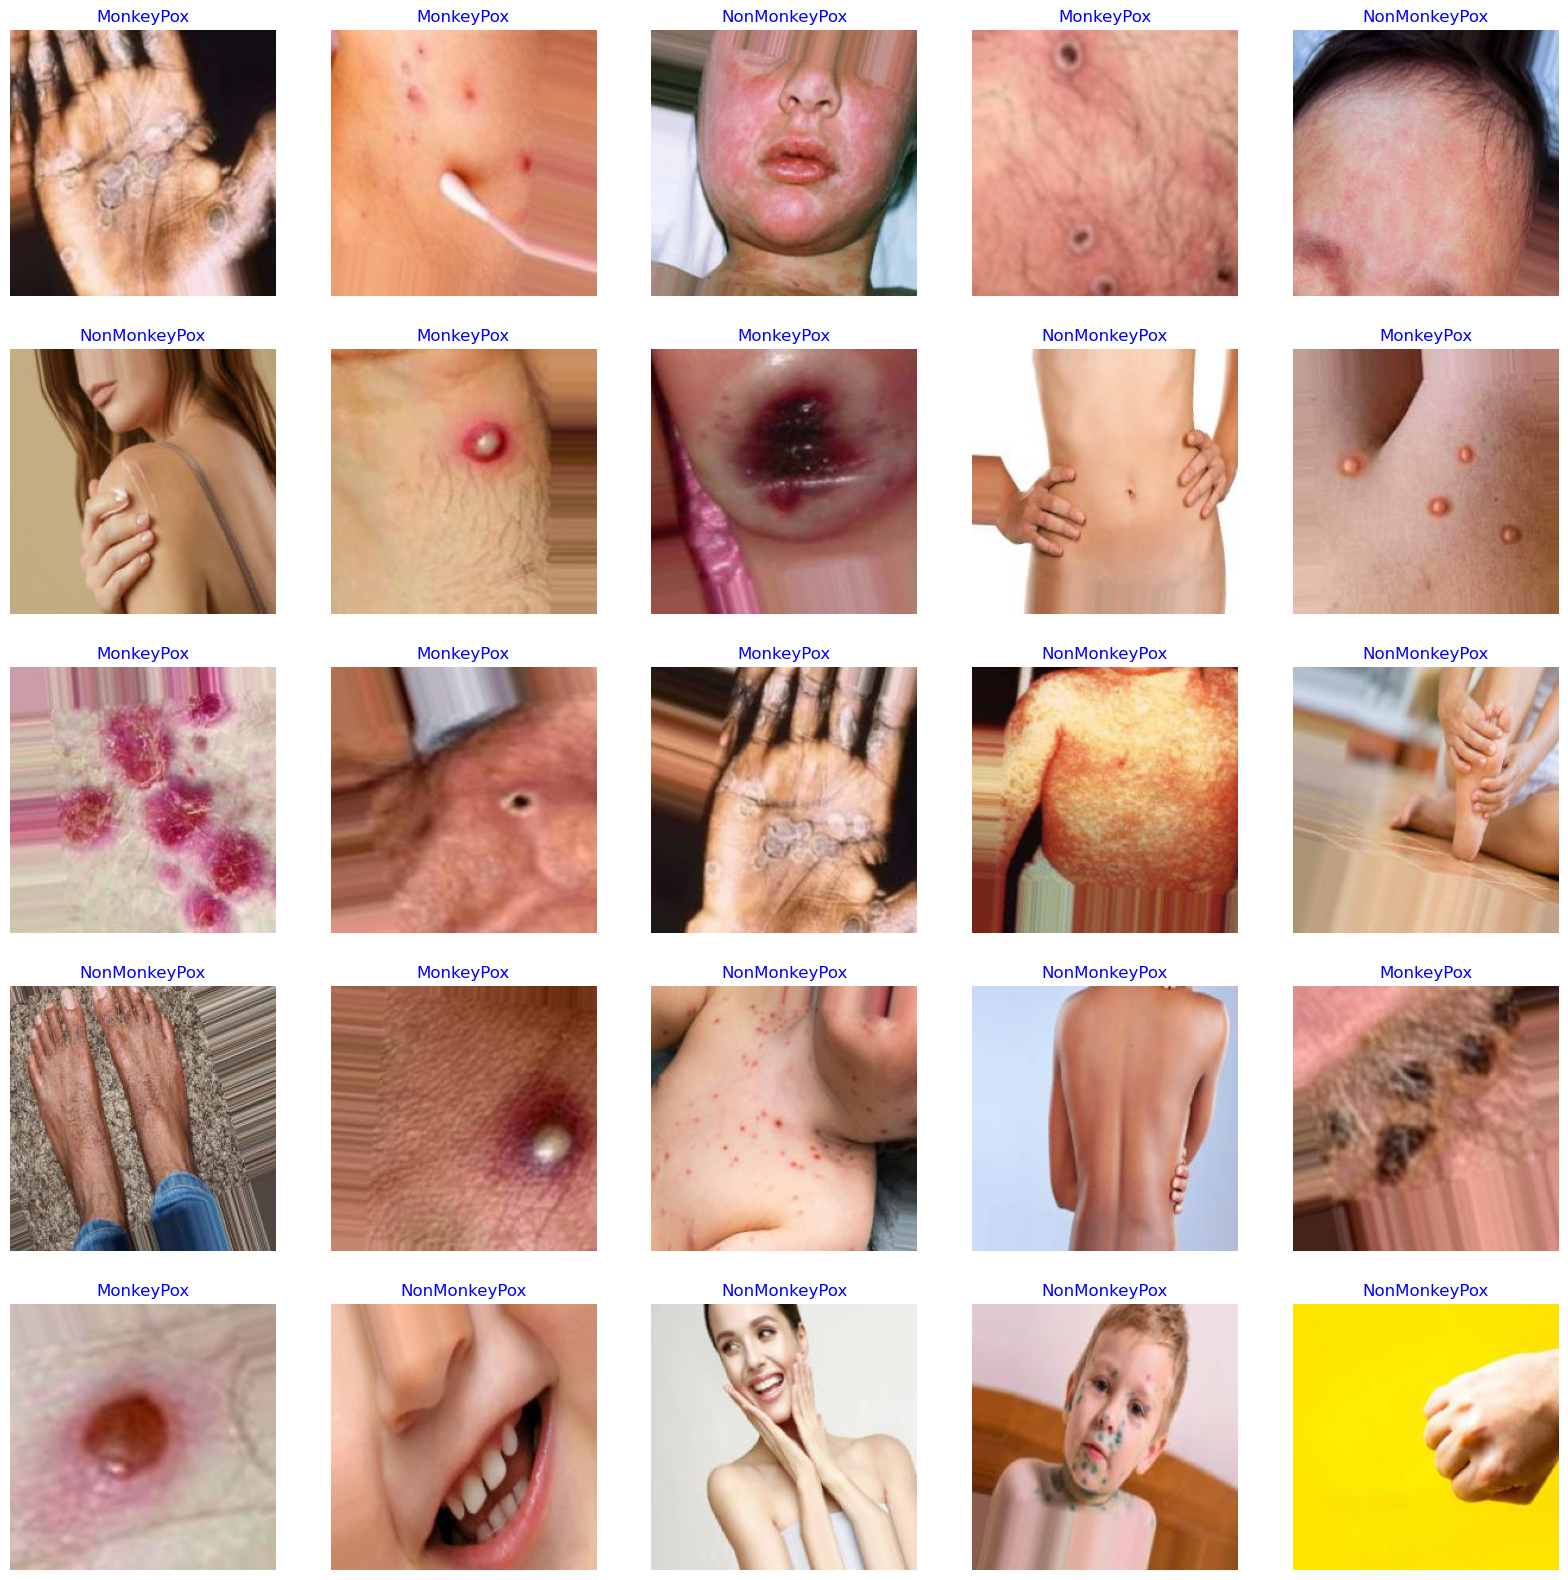

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset directory
tpath = "aug"  # Example: 'data/' containing 'monkeypox' and 'nonmonkeypox'

# Create an ImageDataGenerator for rescaling without augmentation
train_gen = ImageDataGenerator(
    rescale=1. / 255,             # Normalizes the pixel values to the range [0, 1]
    validation_split=0.2          # Splits 20% of the data for validation
)

# Load images from the directory for training
train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(224, 224),        # Resize all images to 224x224
    batch_size=32,                 # Number of images to return in each batch
    subset='training',             # Specify as training data (80% of data)
    shuffle=True                   # Shuffle the images to randomize the batch
)

# Get class indices (which class corresponds to which folder)
g_dict = train_batch.class_indices  # Returns a dictionary like {'monkeypox': 0, 'nonmonkeypox': 1}
classes = list(g_dict.keys())       # List of class names: ['monkeypox', 'nonmonkeypox']

# Get a batch of images and labels
images, labels = next(train_batch)  # Fetch a batch of images and corresponding labels

# Determine the number of images to display (up to 30)
length = len(labels)        # Length of batch size (16 in this case)
sample = min(length, 25)    # Display up to 30 images (or batch size if smaller)

# Set up the plot for displaying images
plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]      # Image from the batch
    plt.imshow(image)      # Display the image
    index = np.argmax(labels[i])  # Get the index of the class label (0 or 1)
    class_name = classes[index]   # Get the class name ('monkeypox' or 'nonmonkeypox')
    plt.title(class_name, color='blue', fontsize=12)  # Set title to class name
    plt.axis('off')        # Hide axis for better display

plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD

# Build the EfficientNetB0 model with transfer learning
EfficientNet_model = Sequential()

# Load the pre-trained EfficientNetB0 model without the top layers
pretrained_model = keras.applications.EfficientNetB0(
    include_top=False,            # Exclude the fully connected layer on top
    input_shape=(224, 224, 3),   # Adjust input shape to match the image size (224x224x3)
    pooling=None,                 # Set pooling to None to apply GlobalAveragePooling later
    weights='imagenet'            # Load ImageNet pre-trained weights
)

# Freeze the EfficientNet layers so that only the custom layers are trained
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained EfficientNet to the Sequential model
EfficientNet_model.add(pretrained_model)

# Add global average pooling layer
EfficientNet_model.add(GlobalAveragePooling2D())

# Add a dropout layer for regularization
EfficientNet_model.add(Dropout(0.5))  # 50% dropout before the final layer

# Add custom fully connected layers
EfficientNet_model.add(Dense(512, activation='relu'))   # Fully connected layer with 512 units
EfficientNet_model.add(Dense(2, activation='softmax'))  # Final layer for 2-class classification


EfficientNet_model.summary()

# Compile the model
EfficientNet_model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=SGD(learning_rate=0.0009),  # Stochastic Gradient Descent optimizer with a small learning rate
    metrics=['accuracy']
)

# Train the model
epochs = 45
history_efficientNet = EfficientNet_model.fit(
    training_data,                # Use training data generator
    validation_data=validation_data,  # Use validation data generator
    epochs=epochs,                # Number of epochs
    verbose=1                     # Print progress during training
)

# Save the trained model
EfficientNet_model.save('efficientnet.h5')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,706,469 (17.95 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.4679 - loss: 0.8380 - val_accuracy: 0.5545 - val_loss: 0.6887
Epoch 2/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5692 - loss: 0.7055 - val_accuracy: 0.7545 - val_loss: 0.5885
Epoch 3/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6874 - loss: 0.6035 - val_accuracy: 0.8212 - val_loss: 0.5197
Epoch 4/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7528 - loss: 0.5345 - val_accuracy: 0.8697 - val_loss: 0.4678
Epoch 5/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7945 - loss: 0.4925 - val_accuracy: 0.8788 - val_loss: 0.4292
Epoch 6/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8079 - loss: 0.4633 - val_accuracy: 0.8939 - val_loss: 0.3976
Epoch 7/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8240 - loss: 0.4333 - val_accuracy: 0.8909 - val_loss: 0.3725
Epoch 8/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8641 - loss: 0.4005 - val_accuracy: 0.8970 - va

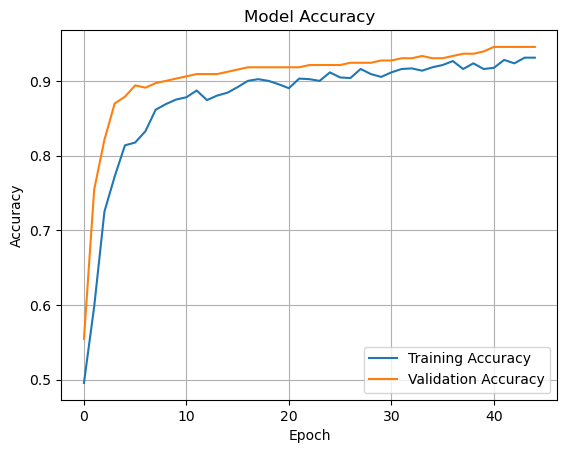

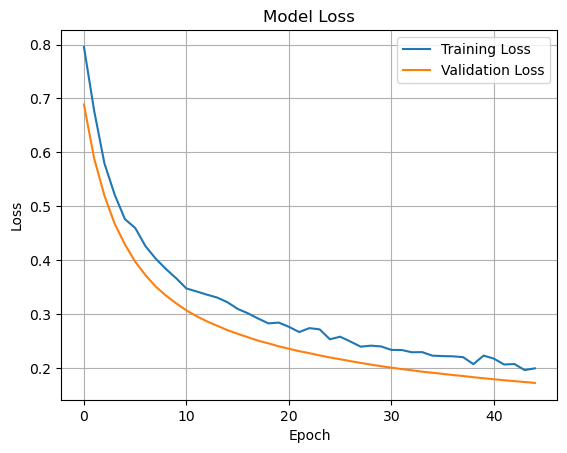

In [4]:
# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history_efficientNet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientNet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.plot(history_efficientNet.history['loss'], label='Training Loss')
plt.plot(history_efficientNet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


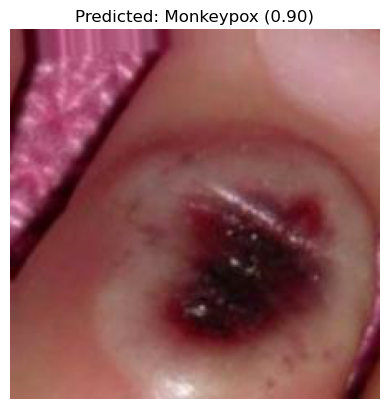

Prediction probabilities: [0.8980709 0.1019291]


In [5]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('efficientnet.h5')

# Load and preprocess the image
img_path = 'test/mp/mp3.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


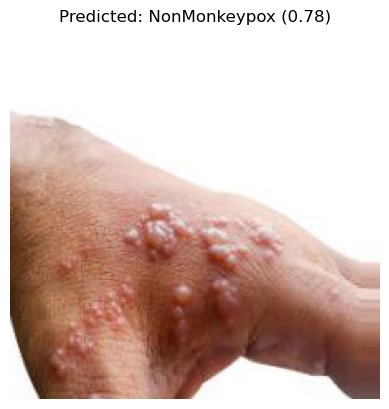

Prediction probabilities: [0.21837871 0.7816213 ]


In [10]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('efficientnet.h5')

# Load and preprocess the image
img_path = 'test/nonmp/nonmp1.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


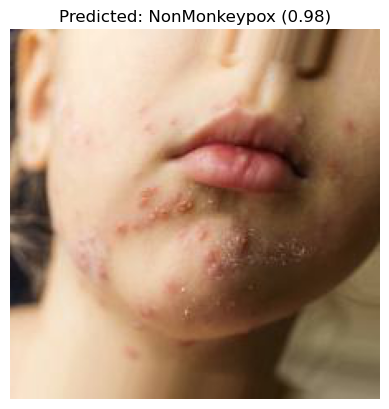

Prediction probabilities: [0.02453507 0.9754649 ]


In [11]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('efficientnet.h5')

# Load and preprocess the image
img_path = 'test/nonmp/nonmp2.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')